# Analyzing a single damped sinusoid

This is the simplest possible example: we analyze a single damped sinusoid in white Gaussian noise. We use this case study to demonstrate some basic features of ringdown, including:

* how to measure generic frequencies and damping rates
* how to set up a fit and run it
* how to make some useful plots

Let's get started!

This first cell must be executed first in order for Stan's multiprocessing code to not crash some MacOS setups; on linux it's not needed.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from pylab import *
import arviz as az
import seaborn as sns
import pandas as pd
import ringdown as rd
import qnm

sns.set(context='notebook', palette='colorblind')

In [3]:
def planck_window(t, tMin=0., tMax=1., tol=.005, rolloff=False):
    """
A smooth function f mapping [tMin, tMax] to [0, 1], with
f(tMin)=0, f(tMax)=1, all derivatives -> 0 as t->0 or t->tMax.
f(t) = 1/(1 + exp(z)) where z = 1/t - 1/(1-t) for the case
tMin=0, tMax=1.
tol controls the minimum deviation of t from 0 or tMax, with
a tol of .005 giving abs(z) < ~200, where exp(z) is 1.e86 or 1.e-86

If rolloff, instead has f(0)=1, f(tMax)=0.
    """
    if rolloff:
        return helper.planck_window(-t, tMin=-tMax, tMax=-tMin, tol=tol)

    if tMax==1. and tMin==0.:
        # If t <= .005, z >= 200. - 1./199. and exp(z) > 1.e86 ~ infinity
        # Similar for t > .995 but exp(z) < 1.e-86 ~ 0
        safe = (t>tol)*(t<(1.-tol))
        safeT = safe*t + (1. - safe)*.5 # use t = 0.5 temporarily for unsafe values
        safeZ = 1./safeT - 1./(1. - safeT)
        return safe*1./(1. + np.exp(safeZ)) + (t >= (1.-tol))

    return planck_window((t-tMin)/(tMax-tMin))

In [4]:
def fac(ffreq,l,m,n,chi,mass):
    t_unit=mass
    ome=qnm.modes_cache(s=-2,l=l,m=m,n=n)(a=chi)[0]
#     return (ffreq-ome)/(ffreq-np.conj(ome))
    return (ffreq*t_unit-ome)/(ffreq*t_unit-np.conj(ome))*(ffreq*t_unit+np.conj(ome))/(ffreq*t_unit+ome)

## Data

Let's create the simplest possible signal and add Gaussian noise to it. Although `rigndown` contains tools to create and maniuplate more complex ringdown and inspiral-merger-ringdown waveforms, we do not need that for this very simple example.

### Signal

First, create a time array based on a specified sampling rate and duration; center it around a target time $t_0$.

In [5]:
# define sampling rate and duration (make these powers of two) 
fsamp = 8192
duration = 4
t0 = 0

delta_t = 1/fsamp
tlen = int(round(duration / delta_t))
epoch = t0 - 0.5*tlen*delta_t

time = np.arange(tlen)*delta_t + epoch

We can now use the above timestmps to create a simulated damped sinusoid starting at $t_0$; for good measure, let's extend the signal before $t_0$ to be a corresponding ring-up (the inference is insensitive to what happens before $t_0$, so we can always just let the signal vanish for $t < t_0$, as long as no step in the data conditioning involves taking a Fourier transform---which is true in the example here).

In [6]:
chi=0.692085186818
M_est=65
t_unit=M_est*2950./2/299792458

In [7]:
mag_from_nr=5*np.array([  0.13657646 +0.95055905j,   3.14657959 -2.71266413j,
       -10.84170677 +3.607406j  ,  22.67958241 -8.01885436j,
       -30.44795174+19.91714543j,  22.09429848-26.19835642j,
        -7.43071591+15.89029183j,   1.0005728  -3.63046079j])

In [8]:
def h22new(a,mass,n,t):
    t_unit1=mass*2950./2/299792458
    htot=[]
#     htot+=[np.exp(0*t)]
    for i in range(n+1):
        grav = qnm.modes_cache(s=-2,l=2,m=2,n=i)
        omega, A1, C = grav(a=a)
        htot+=[np.exp(-1j*(omega)/t_unit1*abs(t))]
    return np.array(htot).T

In [9]:
def construct_qnm(n,chi,M_est,time):
    t_unit1=M_est*2950./2/299792458
    datalist=h22new(chi,M_est,n,time)
    construct=np.sum(datalist*mag_from_nr[:(n+1)],axis=1)#*np.heaviside(time+0*t_unit1,1)
    construct_new=np.nan_to_num(construct)
    return np.real(construct_new)


In [10]:
def get_signal_overtone(n,chi,M_est,time):
    t_unit1=M_est*2950./2/299792458
    grav = qnm.modes_cache(s=-2,l=2,m=2,n=n)
    omega, A1, C = grav(a=chi)
    construct=np.exp(-1j*(omega)/t_unit1*abs(time))*mag_from_nr[n]
    construct_new=np.nan_to_num(construct)
    return np.real(construct_new)

In [11]:
def get_signal(n,chi,M_est,time):
    t_unit1=M_est*2950./2/299792458
    construct_new=construct_qnm(n,chi,M_est,time)
    fpsi422=np.fft.rfft(construct_new,norm='ortho')
    ffreq=np.fft.rfftfreq(len(construct_new),d=(time[1]-time[0])/t_unit1)*2*np.pi
    return rd.Data(construct_new, index=time),ffreq,fpsi422

In [12]:
signal,ffreq,fpsi422 = get_signal(7,chi,M_est,time)
first_overtone = get_signal_overtone(1,chi,M_est,time)
# ffreq,fpsi422 = fft_load(time, **wf_kws)

cond_data=np.fft.irfft(fac(-ffreq,2,2,0,chi,1.)*fpsi422,norm='ortho')

In [30]:
signal_filter=rd.Data(cond_data, index=time)

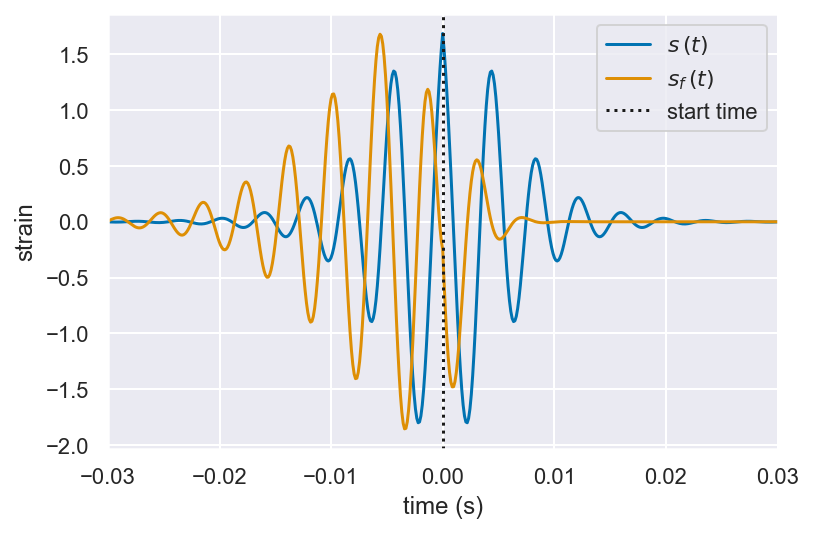

In [13]:
signal.plot(label=r'$s\,(t)$')
plot(time,(cond_data),label=r'$s_{f}\,(t)$')
axvline(t0, ls=':', c='k', label='start time')
xlim(-0.03, 0.03)
xlabel('time (s)')
ylabel('strain')
legend();
savefig('toy_model_waveform_filter.pdf',bbox_inches='tight')

(1e-05, 10)

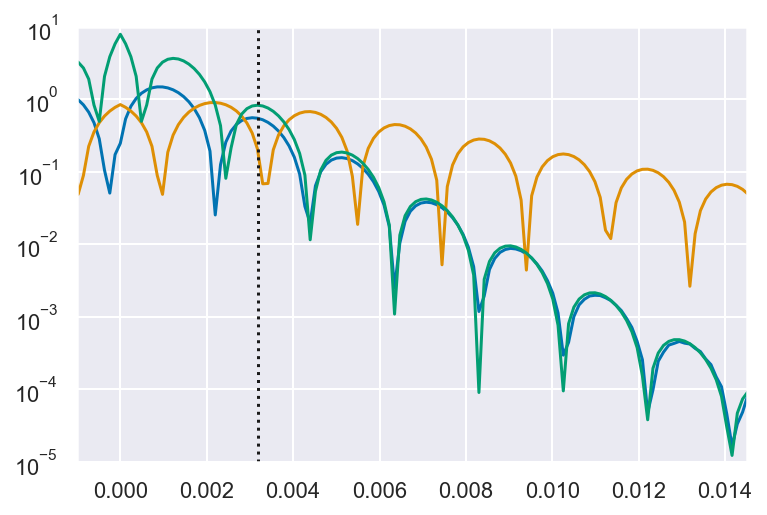

In [14]:
semilogy(time,abs((cond_data)))
semilogy(time,abs((0.5*(np.fft.irfft(fpsi422,norm='ortho')))))
semilogy(time,abs(0.5*first_overtone))
axvline(t0+10*t_unit, ls=':', c='k', label='start time')
xlim(-0.001, 0.0145)
ylim(1e-5,10)

### Noise

Let's add some white Gaussian noise to the signal to obtain our data. This means the autocorrelation function (ACF) of the noise will be $\rho(\tau) = \delta(\tau)$.

In [15]:
rng = np.random.default_rng(12345)
data = signal + rng.normal(0, 1, len(signal))

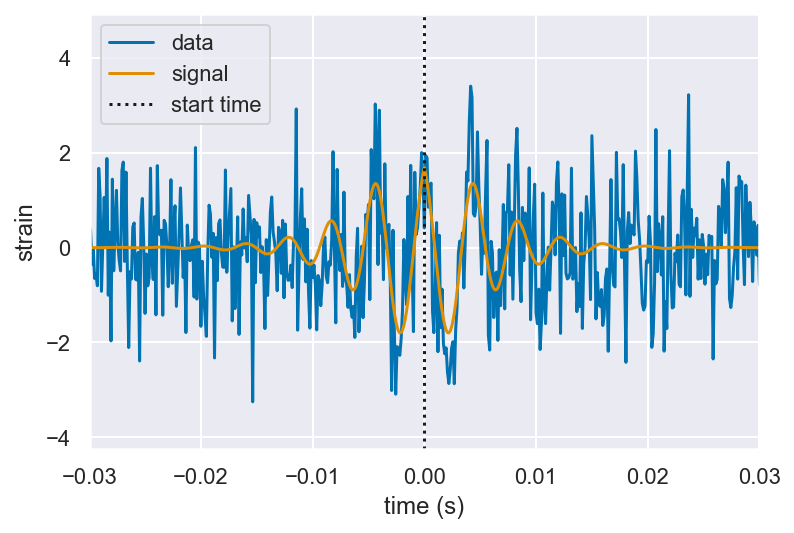

In [16]:
data.plot(label='data')
signal.plot(label='signal')
axvline(t0, ls=':', c='k', label='start time')
xlim(-0.03, 0.03)
xlabel('time (s)')
ylabel('strain')
legend();

For our ringdown analysis, we will need the ACFs corresponding to the noise, which we could estimate empirically from the data; in this case, however, we know the ACF to be a delta function at the origin (corresponding to standard Gaussian noise).

In [17]:
acf = rd.AutoCovariance(zeros_like(data), delta_t=data.delta_t)
acf.iloc[0] = 1

Of course, when working with white noise it is unnecessary to work with the ACF: all we have is a variance (in this case, $\sigma^2 = 1$) and the likelihood simplifies drastically. However, in real life we never have white noise, so `ringdown` expects an ACF and cannot currently accomodate a scalar variance.

## Fit

We are now ready to analyze the ringdown! Let's create a `Fit` object and set up the analysis. To do this, we first need to specify the model to be fit and the number (or kind) of modes to be used. In this case, we will be using the `ftau` model, which is parameterized in terms of damped sinusoids with generic frequencies $f_n$, damping rates $\gamma_n = 1/\tau_n$, amplitudes $A_n$, and phases $\phi_n$, defined such that successive modes are ordered in terms of damping rate ($\gamma_n < \gamma_{n+1}$); for this is example, we will only inject and recover a single mode.

In [18]:
fit = rd.Fit(model='mchi_aligned_ftau', modes=[(1, -2, 2, 2, 1)])
print(fit.valid_model_options)

fit.add_data(data, acf=acf)
fit.filter_data(chi,M_est*1.,0)
fit.set_target(t0+0*t_unit, duration=0.03)

['A_scale', 'M_min', 'M_max', 'chi_min', 'chi_max', 'flat_A']


(0.0, 0.03)

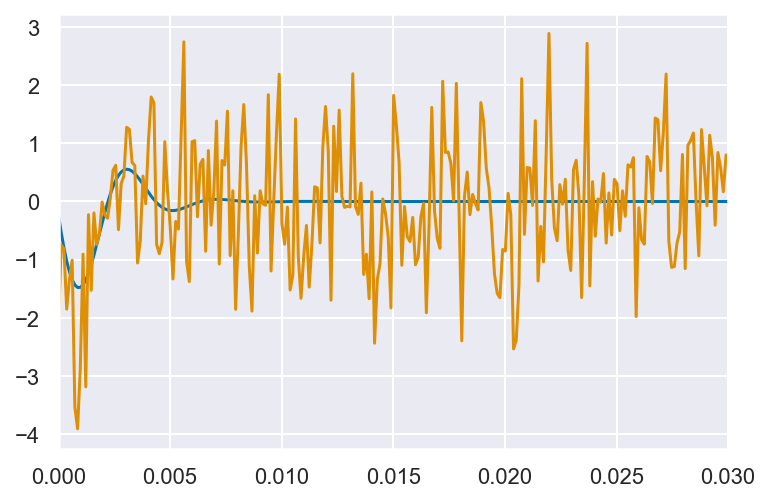

In [19]:
wd=fit.analysis_data
plot(time,((cond_data)))
plot(wd[None], label='H1')
xlim(t0,t0+0.03)
# savefig('res.pdf')

Finally, let's set some reasonable prior based on our knowledge of the true signal.

In [20]:
fit.update_prior(A_scale=2, M_min=25.0, M_max=140.0, flat_A=True)
# fit.update_prior(A_scale=2, M_min=35.0, M_max=140.0, cosi_max=-0.99, flat_A=True)
fit.prior_settings

{'A_scale': 2,
 'M_min': 25.0,
 'M_max': 140.0,
 'chi_min': 0,
 'chi_max': 0.99,
 'flat_A': True}

Our fit is ready to go; run it!

<div class="alert alert-info">

Note

The `run()` method will automatically compile the `PyStan` code the first time any fit runs in a given session, which can take a while.  Subsequent runs will use the precompiled code and be much quicker.

</div>

In [21]:
fit.run(target_accept=0.96)

## Result

In [22]:
az.summary(fit.result, var_names=['A','phi', 'M', 'chi'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A[0],3.859,1.078,1.862,5.821,0.041,0.029,631.0,689.0,1.0
phi[0],-1.890,0.379,-2.486,-1.460,0.011,0.012,754.0,822.0,1.0
M,79.931,18.648,48.462,116.903,0.895,0.687,577.0,288.0,1.0
chi,0.500,0.238,0.035,0.845,0.008,0.006,848.0,639.0,1.0


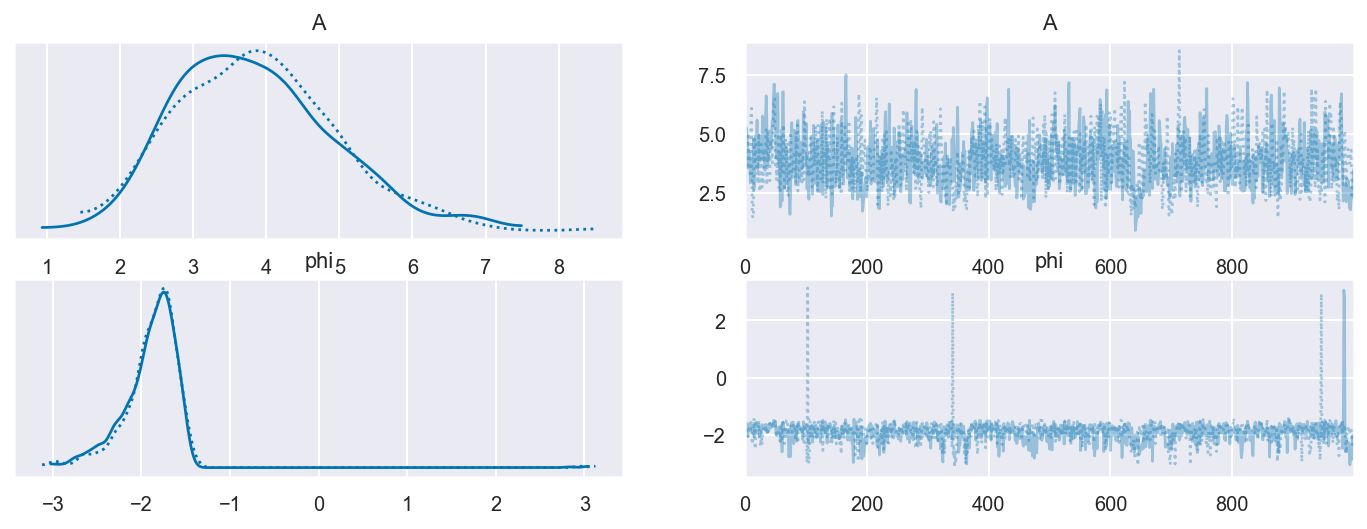

In [23]:
az.plot_trace(fit.result, var_names=['A', 'phi'], compact=True);

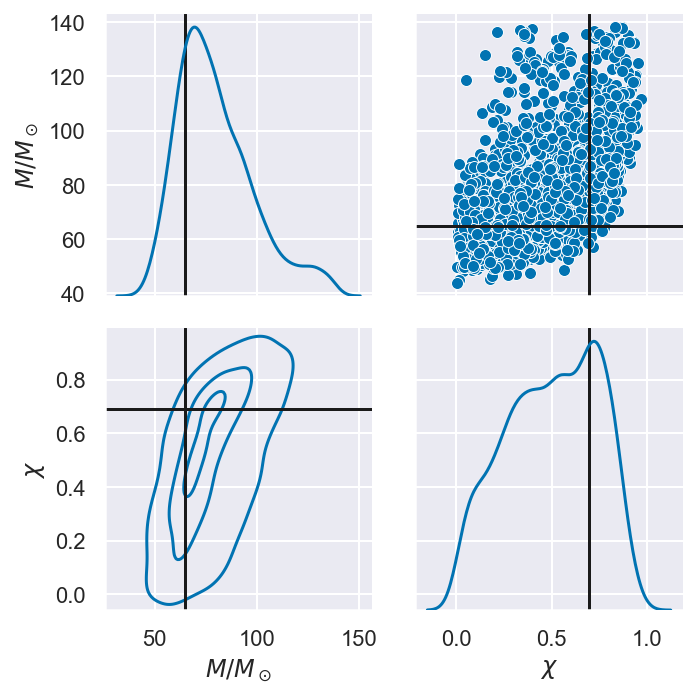

In [26]:
mIMR = M_est
chiIMR = chi

df = pd.DataFrame({
    r'$M / M_\odot$': fit.result.posterior.M.values.flatten(),
    r'$\chi$': fit.result.posterior.chi.values.flatten()
})
pg = sns.PairGrid(df, diag_sharey=False)
pg.map_diag(sns.kdeplot);
pg.map_upper(sns.scatterplot);
pg.map_lower(rd.kdeplot_2d_clevels, levels=[0.9, 0.5, 0.1])

pg.axes[0,0].axvline(mIMR, color='k')
pg.axes[0,1].axvline(chiIMR, color='k')
pg.axes[0,1].axhline(mIMR, color='k')
pg.axes[1,0].axhline(chiIMR, color='k')
pg.axes[1,0].axvline(mIMR, color='k')
pg.axes[1,1].axvline(chiIMR, color='k')
# pg.savefig('res.pdf')

In [27]:
import os
os.system('say "hi"')

0

# Reconstructions

In [28]:

# median reconstruction and 90%-credible envelope
wfs = [quantile(fit.result.posterior.h_det.values, q, axis=(0,1))[0,:]
       for q in [0.5, 0.95, 0.05]]
wfs = [rd.Data(wf, index=fit.result.constant_data.times[0,:]) for wf in wfs]

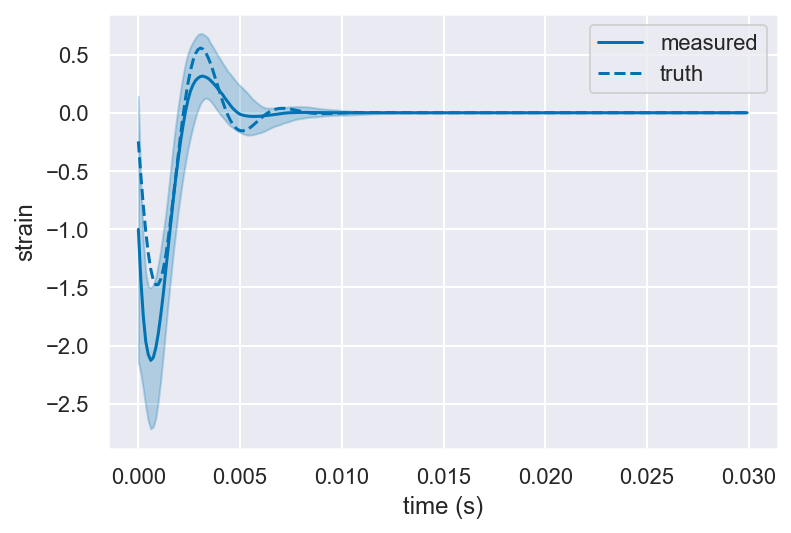

In [34]:

# plot reconstructions computed above
m, u, d = wfs
l, = plot(m, label='measured')
fill_between(m.time, u, d, color=l.get_color(), alpha=0.25)

# plot truth (using time mask to select right times)
plot(signal_filter[m.time], c=l.get_color(), ls='--', label='truth')
xlabel('time (s)')
ylabel('strain')
legend();

In [1551]:
snrs_mf = fit.compute_posterior_snrs(optimal=False)

In [1552]:
injsnr_mf = dot(signal_filter[m.time], data[m.time]) / linalg.norm(signal_filter[m.time])

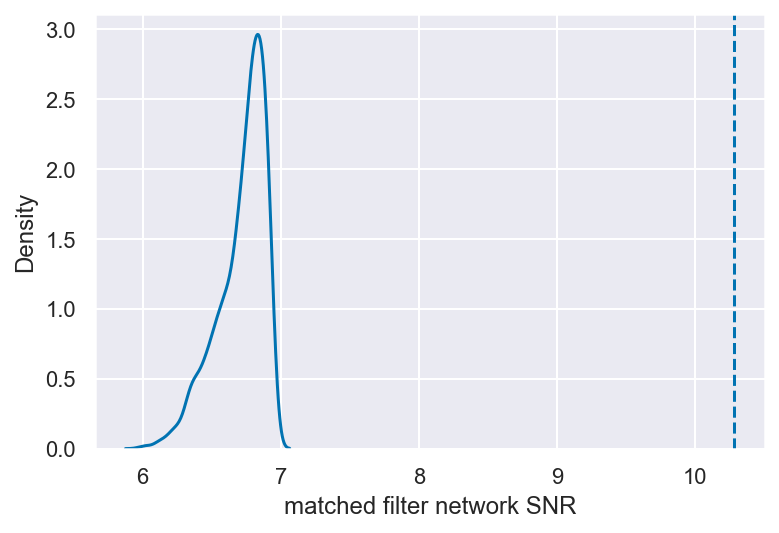

In [1553]:
sns.kdeplot(snrs_mf)
axvline(injsnr_mf, ls='--');
xlabel('matched filter network SNR');